##### Read 2019 Sales Data from Parquet Directory

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, date_format, expr, round, sum
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns

In [72]:
spark = SparkSession.builder.appName("Challenge_3").getOrCreate()

In [73]:
type(spark)

pyspark.sql.session.SparkSession

In [74]:
file_path = "./output/sales/"

sales_data_df = spark.read.parquet(file_path)

sales_data_df.show(10, truncate=False)

+-------+--------------------------+--------+------+-------------------+--------------------------------------+-------------+-----+----------+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                          |City         |State|ReportYear|Month|
+-------+--------------------------+--------+------+-------------------+--------------------------------------+-------------+-----+----------+-----+
|296174 |27in FHD Monitor          |1       |149.99|2019-12-29 09:38:00|982 Cherry St, Portland, OR 97035     |Portland     |OR   |2019      |12   |
|296176 |Wired Headphones          |1       |11.99 |2019-12-11 17:56:00|893 Cedar St, San Francisco, CA 94016 |San Francisco|CA   |2019      |12   |
|296475 |27in 4K Gaming Monitor    |1       |389.99|2019-12-27 12:57:00|309 South St, Los Angeles, CA 90001   |Los Angeles  |CA   |2019      |12   |
|297038 |Apple Airpods Headphones  |1       |150.0 |2019-12-28 20:47:00|778 Park St, New York City, NY 100

In [75]:
sales_data_df.count()

185686

##### Question 1: What was the best month in terms of sales?

In [76]:
sales_data_df.withColumn("TotalSales", expr("Price * Quantity"))\
            .groupBy("Month")\
            .agg(sum("TotalSales").alias("GrandTotalSales"))\
            .show(5, truncate=False)

+-----+------------------+
|Month|GrandTotalSales   |
+-----+------------------+
|12   |4608295.6761312485|
|1    |1821413.1513473988|
|6    |2576280.137305975 |
|3    |2804973.335673094 |
|5    |3150616.21493268  |
+-----+------------------+
only showing top 5 rows



In [77]:
sales_data_df.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: string (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ReportYear: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [78]:
sales_data_df.groupBy("Month").agg(count("Month")).show(truncate=False)

+-----+------------+
|Month|count(Month)|
+-----+------------+
|12   |24944       |
|1    |9699        |
|6    |13535       |
|3    |15128       |
|5    |16552       |
|9    |11603       |
|4    |18257       |
|8    |11943       |
|7    |14275       |
|10   |20249       |
|11   |17544       |
|2    |11957       |
+-----+------------+



In [79]:
sales_q1_df = sales_data_df.select(
    col("OrderID"),
    col("Month"),
    col("Price"),
    col("Quantity"),
    expr("Price * Quantity").alias("Sales"))

In [80]:
sales_q1_df.show(10, truncate=False)

+-------+-----+------+--------+------+
|OrderID|Month|Price |Quantity|Sales |
+-------+-----+------+--------+------+
|296174 |12   |149.99|1       |149.99|
|296176 |12   |11.99 |1       |11.99 |
|296475 |12   |389.99|1       |389.99|
|297038 |12   |150.0 |1       |150.0 |
|297142 |12   |700.0 |1       |700.0 |
|297342 |12   |11.95 |1       |11.95 |
|297695 |12   |99.99 |1       |99.99 |
|297902 |12   |11.99 |1       |11.99 |
|297992 |12   |600.0 |1       |600.0 |
|298194 |12   |14.95 |1       |14.95 |
+-------+-----+------+--------+------+
only showing top 10 rows



In [81]:
sales_q1_df = sales_q1_df.groupBy("Month")\
                        .agg(round(sum("Sales"), 2).alias("TotalSales"))\
                        .orderBy("TotalSales", ascending=False)

In [82]:
sales_q1_df.show(10, truncate=False)

+-----+----------+
|Month|TotalSales|
+-----+----------+
|12   |4608295.68|
|10   |3734777.84|
|4    |3389217.96|
|11   |3197875.03|
|5    |3150616.21|
|3    |2804973.34|
|7    |2646461.31|
|6    |2576280.14|
|8    |2241083.36|
|2    |2200078.07|
+-----+----------+
only showing top 10 rows



In [83]:
pd_sales_q1 = sales_q1_df.orderBy("Month", ascending=False).toPandas()

In [84]:
pd_sales_q1

,Month,TotalSales
0,12,4608295.68
1,11,3197875.03
2,10,3734777.84
3,9,2094465.68
4,8,2241083.36
5,7,2646461.31
6,6,2576280.14
7,5,3150616.21
8,4,3389217.96
9,3,2804973.34


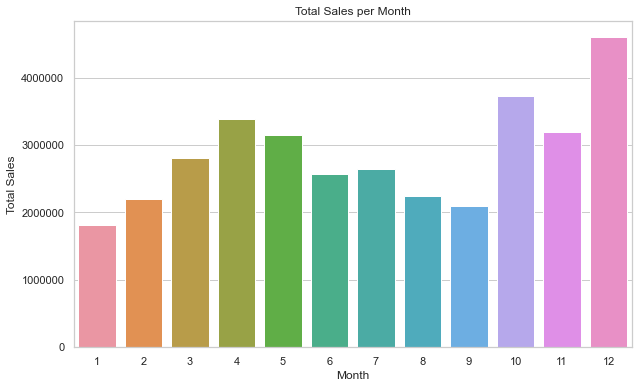

In [87]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="Month", y="TotalSales", data=pd_sales_q1).set_title("Total Sales per Month")
plt.ylabel("Total Sales")
plt.show()

- December is best month in terms of sales.

##### What City Actually Sold the Most Products?

In [24]:
sales_data_df.groupBy("City")\
            .agg(sum("Quantity").alias("SumQuantity"))\
            .orderBy("SumQuantity", ascending=False)\
            .show(5, truncate=False)

+-------------+-----------+
|City         |SumQuantity|
+-------------+-----------+
|San Francisco|50169      |
|Los Angeles  |33247      |
|New York City|27903      |
|Boston       |22494      |
|Dallas       |16707      |
+-------------+-----------+
only showing top 5 rows



- San Francisco sold the most products

##### What time should we display advertisements to maximize the likelihood of customers buying products?

+-------+------------------------+--------+------+-------------------+-------------------------------------+-------------+-----+----------+-----+----+----------+
|OrderID|Product                 |Quantity|Price |OrderDate          |StoreAddress                         |City         |State|ReportYear|Month|hour|TotalSales|
+-------+------------------------+--------+------+-------------------+-------------------------------------+-------------+-----+----------+-----+----+----------+
|296174 |27in FHD Monitor        |1       |149.99|2019-12-29 09:38:00|982 Cherry St, Portland, OR 97035    |Portland     |OR   |2019      |12   |09  |149.99    |
|296176 |Wired Headphones        |1       |11.99 |2019-12-11 17:56:00|893 Cedar St, San Francisco, CA 94016|San Francisco|CA   |2019      |12   |17  |11.99     |
|296475 |27in 4K Gaming Monitor  |1       |389.99|2019-12-27 12:57:00|309 South St, Los Angeles, CA 90001  |Los Angeles  |CA   |2019      |12   |12  |389.99    |
|297038 |Apple Airpods Headp

In [53]:
updated_sales_data_df = sales_data_df.withColumn("hour", date_format("OrderDate", "HH"))\
                                    .withColumn("TotalSales", expr("Price * Quantity").cast(FloatType()))

updated_sales_data_df.groupBy(col("hour").cast(IntegerType()))\
                    .agg(sum(col("TotalSales")))\
                    .show(5, truncate=False)

+-----------------+------------------+
|CAST(hour AS INT)|sum(TotalSales)   |
+-----------------+------------------+
|12               |2314359.8384149075|
|22               |1606243.8415923119|
|1                |460563.8978149891 |
|13               |2152369.9689331055|
|16               |1902523.1909103394|
+-----------------+------------------+
only showing top 5 rows



- 12 O'Clock

##### What products are often sold together in the state "NY"?

In [55]:
sales_data_df.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: string (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ReportYear: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [56]:
sales_data_df.select("OrderID").count()

185686

In [57]:
sales_data_df.select("OrderID").distinct().count()

178437

In [ ]:
updated_sales_data_df2 = sales_data_df.groupBy